In [1]:
import sys
sys.path.append(
    "/home/katrin/Documents/gammapy"
)
print(sys.path)
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

['/home/katrin/Documents/nuisance_summary/Eff_area', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python38.zip', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/lib-dynload', '', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages', '/home/katrin/Documents/gammapy']
loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 9kdqqgyv 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

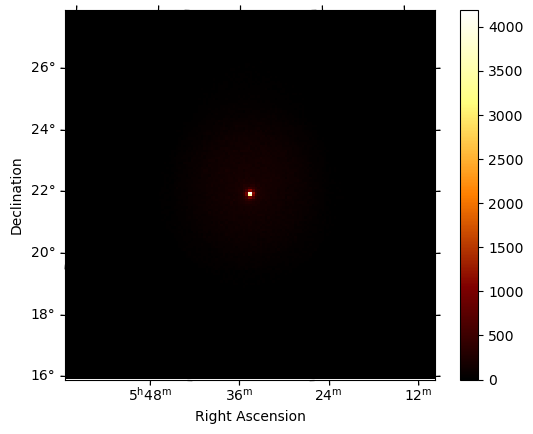

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'
path_crab = '/home/katrin/Documents/Crab'
path = '/home/katrin/Documents'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

dataset_asimov= dataset_asimov.slice_by_energy(0.1 *u.TeV, 20 *u.TeV)


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
true_energy = dataset_asimov.counts.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.015
tilt_pos = 0.015
tilt_cor = 0



In [5]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [6]:
colors  = ['blue', 'green', 'red']

In [7]:


shift_def = -0.15
shift_pos = +0.15
shift_cor = 0.0

tilt_def = +0.02
tilt_pos = -0.02
tilt_cor = 0

sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        rnd = False)
dataset_cor_1 = sys_d_cor.create_dataset()
dataset_cor_2 = sys_d_cor.create_dataset()
dataset_def = sys_d_cor.create_dataset()



/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1103: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


<AxesSubplot: xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>

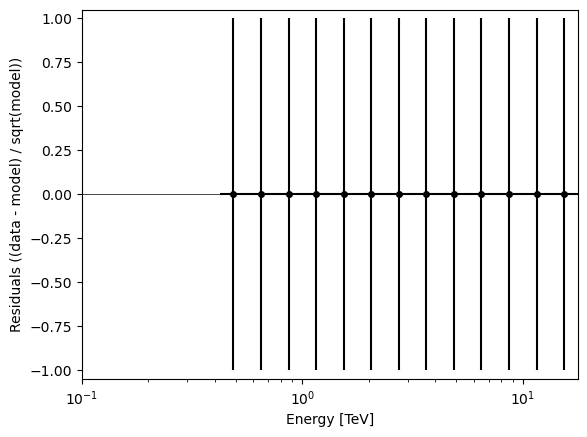

In [8]:
dataset_def.plot_residuals_spectral(method = 'diff/sqrt(model)')

In [9]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt




### Correct fit of dataset Cor stategy 1

In [10]:
fit = Fit(store_trace=True)
#tol: Access tolerance for convergence with the EDM criterion. default: 0.1
# The convergence is detected when edm < edm_max, where edm_max is calculated as
# edm_max = 0.002 * tol * errordef
minuit_opts = {"tol": 0.001, "strategy": 1}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts
result = fit.run(dataset_cor_1)

In [11]:
fit.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.876e+05                 │              Nfcn = 81               │
│ EDM = 1.68e-08 (Goal: 2e-06)     │            time = 0.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.08    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   1.00    │   0.09    │            │            │         │         │       │
│ 2 │ par_002_sigma     │    1.9    │    1.2    │            │            │    0    │         │       │
│ 3 │ par_003_norm      │  1.0000   │  0.0021   │            │            │         │         │       │
│ 4 │ par_004_tilt      │  0.0000   │  0.0023   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude     par_002_sigma      par_003_norm      par_004_tilt │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │           0.00648           0.00544         -0.000822         -1.04e-05          -1.3e-05 │
│ par_001_amplitude │           0.00544           0.00901           0.00513         -1.69e-05         -8.87e-06 │
│     par_002_sigma │         -0.000822           0.00513              1.38         -8.05e-06          6.22e-06 │
│      par_003_norm │         -1.04e-05         -1.69e-05         -8.05e-06          4.45e-06          2.89e-06 │
│      par_004_tilt │          -1.3e-05         -8.87e-06          6.22e-06          2.89e-06          5.29e-06 │
└───────────────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [12]:
edm = fit.minuit.fmin.edm
edm_goal = fit.minuit.fmin.edm_goal
print(fit.minuit.fmin.is_above_max_edm)

False


### Correct fit of dataset Cor stategy 2

In [13]:
fit_2 = Fit(store_trace=True)
#tol: Access tolerance for convergence with the EDM criterion. default: 0.1
# The convergence is detected when edm < edm_max, where edm_max is calculated as
# edm_max = 0.002 * tol * errordef
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_2.backend = "minuit"
fit_2.optimize_opts = minuit_opts
result = fit_2.run(dataset_cor_2)

In [14]:
fit_2.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.876e+05                 │              Nfcn = 162              │
│ EDM = 6.57e-09 (Goal: 2e-06)     │            time = 1.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.08    │            │            │         │         │       │
│ 1 │ par_001_amplitude │    1.0    │    0.1    │            │            │         │         │       │
│ 2 │ par_002_sigma     │    1.9    │    1.2    │            │            │    0    │         │       │
│ 3 │ par_003_norm      │  1.0000   │  0.0021   │            │            │         │         │       │
│ 4 │ par_004_tilt      │  0.0000   │  0.0023   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude     par_002_sigma      par_003_norm      par_004_tilt │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │           0.00686           0.00591          -0.00144         -1.14e-05         -1.39e-05 │
│ par_001_amplitude │           0.00591           0.00954           0.00495         -1.81e-05         -9.96e-06 │
│     par_002_sigma │          -0.00144           0.00495              1.58         -6.89e-06          8.92e-06 │
│      par_003_norm │         -1.14e-05         -1.81e-05         -6.89e-06          4.46e-06          2.91e-06 │
│      par_004_tilt │         -1.39e-05         -9.96e-06          8.92e-06          2.91e-06          5.31e-06 │
└───────────────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [15]:
edm_2 = fit_2.minuit.fmin.edm
edm_goal_2 = fit_2.minuit.fmin.edm_goal
print(fit_2.minuit.fmin.is_above_max_edm)

False


### Default fit of datasets_neg

In [16]:
fit_def = Fit()
result_def = fit_def.run(dataset_def)
result_def_opti = fit_def.optimize(dataset_def)

In [17]:
fit_def.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.876e+05                 │              Nfcn = 88               │
│ EDM = 4.35e-08 (Goal: 0.0002)    │            time = 0.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.08    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   1.00    │   0.09    │            │            │         │         │       │
│ 2 │ par_002_sigma     │    1.9    │    1.2    │            │            │    0    │         │       │
│ 3 │ par_003_norm      │  1.0000   │  0.0021   │            │            │         │         │       │
│ 4 │ par_004_tilt      │  0.0000   │  0.0023   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude     par_002_sigma      par_003_norm      par_004_tilt │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │           0.00648           0.00544         -0.000822         -1.05e-05          -1.3e-05 │
│ par_001_amplitude │           0.00544           0.00901           0.00514          -1.7e-05         -8.97e-06 │
│     par_002_sigma │         -0.000822           0.00514              1.38         -8.15e-06          6.14e-06 │
│      par_003_norm │         -1.05e-05          -1.7e-05         -8.15e-06          4.46e-06          2.91e-06 │
│      par_004_tilt │          -1.3e-05         -8.97e-06          6.14e-06          2.91e-06          5.31e-06 │
└───────────────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

1.6773325666482854e-08 2e-06
False


<IPython.core.display.Javascript object>


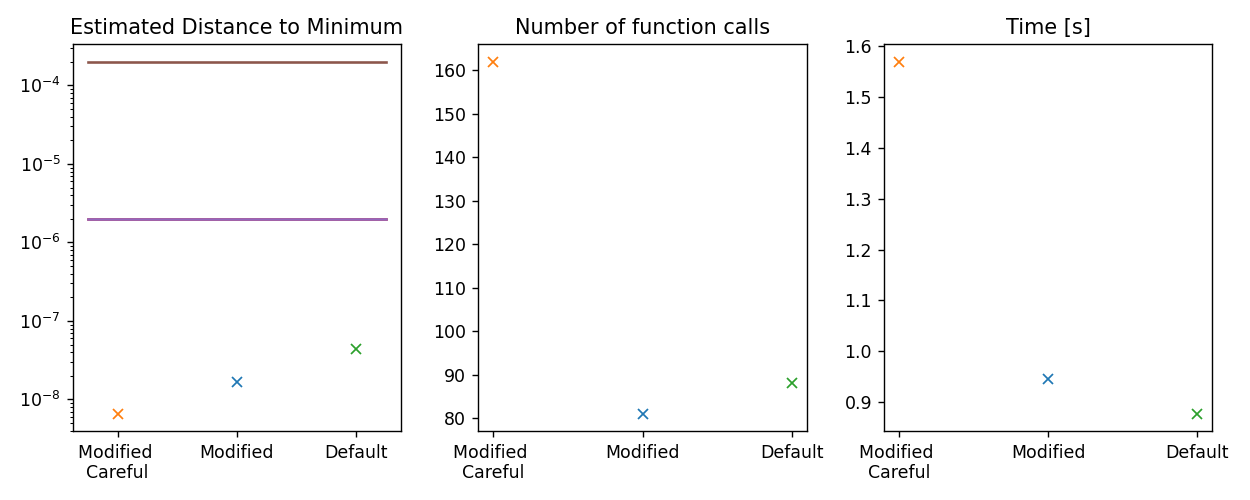

In [79]:
edm_def = fit_def.minuit.fmin.edm
edm_goal_def = fit_def.minuit.fmin.edm_goal

print(edm, edm_goal)
print(fit_def.minuit.fmin.is_above_max_edm)

fig,axs = plt.subplots(1,3, figsize = (10,4))

ax = axs[0]
ax.plot(0, edm, 'x', label = '')
ax.plot(-0.4, edm_2, 'x', label = '')
ax.plot(0.4, edm_def, 'x', label = '')
ax.plot([-0.5, 0.5], [edm_goal]*2, label = 'modified goal')
ax.plot([-0.5, 0.5], [edm_goal_2]*2, label = 'modified goal 2')
ax.plot([-0.5, 0.5], [edm_goal_def]*2, label = 'default goal')

ax.set_yscale('log')
#ax.legend()
ax.set_xticks([-0.4, 0., 0.4], ['Modified \nCareful', 'Modified', 'Default'])
ax.set_title("Estimated Distance to Minimum")

ax = axs[1]
ax.plot(0, fit.minuit.fmin.nfcn, 'x', label = '')
ax.plot(-0.4, fit_2.minuit.fmin.nfcn, 'x', label = '')
ax.plot(0.4, fit_def.minuit.fmin.nfcn, 'x', label = '')
ax.set_xticks([-0.4, 0., 0.4], ['Modified \nCareful', 'Modified', 'Default'])
ax.set_title("Number of function calls")

ax = axs[2]
ax.plot(0, fit.minuit.fmin.time, 'x', label = '')
ax.plot(-0.4, fit_2.minuit.fmin.time, 'x', label = '')
ax.plot(0.4, fit_def.minuit.fmin.time, 'x', label = '')
ax.set_xticks([-0.4, 0., 0.4], ['Modified \nCareful', 'Modified', 'Default'])
ax.set_title("Time [s]")

plt.tight_layout()

### Comparison

<IPython.core.display.Javascript object>


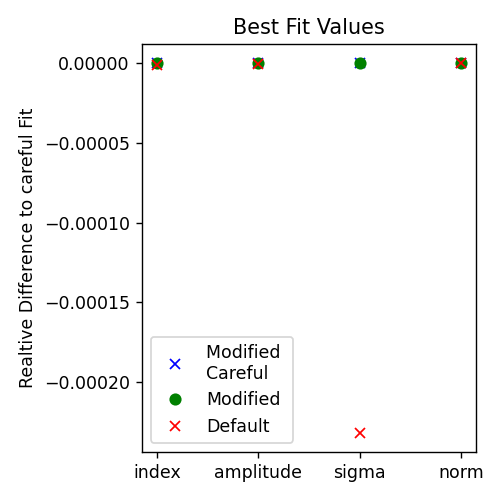

In [80]:
fig = plt.figure(figsize = (4,4))
labels = ['Modified \nCareful', 'Modified', 'Default']
fmts = ['x', 'o', 'x']
datasets = [dataset_cor_2, dataset_cor_1, dataset_def]
par_names = dataset_cor_1.models.parameters.free_parameters.names[:-1]
for i, p in enumerate(par_names):
    par_ = datasets[0].models.parameters[p]
    parerror_ = par_.value
    
    for j, d in enumerate(datasets):
        par = d.models.parameters[p]
        plt.plot(i, (parerror_ - par.value)/ parerror_  , fmts[j], color = colors[j], label = labels[j])
        
plt.xticks(np.arange(len(par_names)), par_names)
plt.ylabel("Realtive Difference to careful Fit")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.title('Best Fit Values')

plt.tight_layout()


<IPython.core.display.Javascript object>


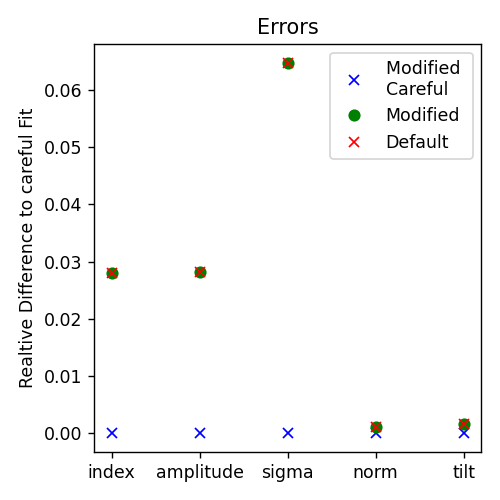

In [81]:
fig = plt.figure(figsize = (4,4))
labels = ['Modified \nCareful', 'Modified', 'Default']
fmts = ['x', 'o', 'x']
datasets = [dataset_cor_2, dataset_cor_1, dataset_def]
par_names = dataset_cor_1.models.parameters.free_parameters.names
for i, p in enumerate(par_names):
    par_ = datasets[0].models.parameters[p]
    parerror_ = par_.error
    
    for j, d in enumerate(datasets):
        par = d.models.parameters[p]
        plt.plot(i, (parerror_ - par.error)/ parerror_  , fmts[j], color = colors[j], label = labels[j])
        
plt.xticks(np.arange(len(par_names)), par_names)
plt.ylabel("Realtive Difference to careful Fit")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.title('Errors')

plt.tight_layout()


<IPython.core.display.Javascript object>


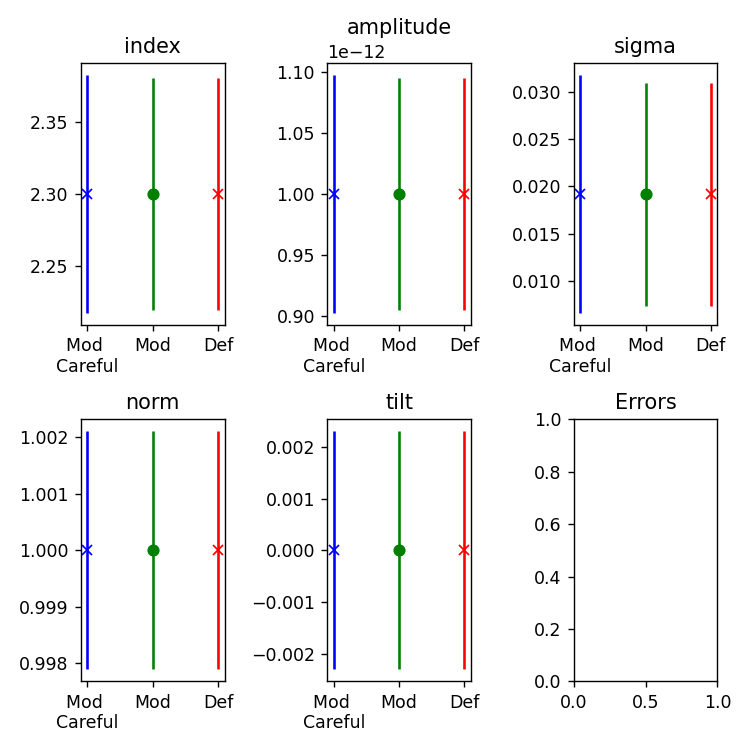

In [103]:
fig, ax = plt.subplots(2,3,figsize = (6,6))
labels = ['Modified \nCareful', 'Modified', 'Default']
fmts = ['x', 'o', 'x']
datasets = [dataset_cor_2, dataset_cor_1, dataset_def]
par_names = dataset_cor_1.models.parameters.free_parameters.names
for i, p in enumerate(par_names):
    par_ = datasets[0].models.parameters[p]
    parerror_ = par_.error
    for j, d in enumerate(datasets):
        par = d.models.parameters[p]
        ax.flatten()[i].errorbar(0 + j, par.value, yerr = par.error, fmt=fmts[j],
                             color = colors[j], label = labels[j])
        ax.flatten()[i].set_title(p)
    ax.flatten()[i].set_xticks(np.arange(3), ['Mod \nCareful', 'Mod', 'Def'])
        
plt.title('Errors')

plt.tight_layout()


In [82]:
print(dataset_cor_1.models.parameters.free_parameters.to_table())

  type      name     value         unit        error      min    max frozen is_norm is_penalised link
-------- --------- ---------- -------------- --------- --------- --- ------ ------- ------------ ----
spectral     index 2.3000e+00                8.053e-02       nan nan  False   False        False     
spectral amplitude 1.0000e-12 cm-2 s-1 TeV-1 9.493e-14       nan nan  False    True        False     
 spatial     sigma 1.9174e-02            deg 1.175e-02 0.000e+00 nan  False   False        False     
spectral      norm 1.0000e+00                2.109e-03       nan nan  False    True        False     
spectral      tilt 0.0000e+00                2.301e-03       nan nan  False   False        False     


In [83]:
print(dataset_def.models.parameters.free_parameters.to_table())

  type      name     value         unit        error      min    max frozen is_norm is_penalised link
-------- --------- ---------- -------------- --------- --------- --- ------ ------- ------------ ----
spectral     index 2.3000e+00                8.053e-02       nan nan  False   False        False     
spectral amplitude 1.0000e-12 cm-2 s-1 TeV-1 9.493e-14       nan nan  False    True        False     
 spatial     sigma 1.9178e-02            deg 1.175e-02 0.000e+00 nan  False   False        False     
spectral      norm 1.0000e+00                2.109e-03       nan nan  False    True        False     
spectral      tilt 1.1582e-09                2.301e-03       nan nan  False   False        False     


In [84]:
print(dataset_cor_2.models.parameters.free_parameters.to_table())

  type      name     value         unit        error      min    max frozen is_norm is_penalised link
-------- --------- ---------- -------------- --------- --------- --- ------ ------- ------------ ----
spectral     index 2.3000e+00                8.285e-02       nan nan  False   False        False     
spectral amplitude 1.0000e-12 cm-2 s-1 TeV-1 9.767e-14       nan nan  False    True        False     
 spatial     sigma 1.9174e-02            deg 1.256e-02 0.000e+00 nan  False   False        False     
spectral      norm 1.0000e+00                2.111e-03       nan nan  False    True        False     
spectral      tilt 1.2993e-09                2.305e-03       nan nan  False   False        False     
